In [137]:
from bauer.utils.data import load_garcia2022
from bauer.models import MagnitudeComparisonModel
import numpy as np
import pandas as pd
import seaborn as sns
from bauer.utils.plotting import plot_ppc
from .utils import create_design_magJudge

ImportError: attempted relative import with no known parent package

In [165]:
df = load_garcia2022()

model = MagnitudeComparisonModel(df)
model.build_estimation_model()
trace = model.sample(draws=1000, tune=1000)

{'n1_prior_mu': mean, 'n1_prior_std': std, 'n2_prior_std': std, 'threshold': 0.0, 'n1_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_prior_mu': AdvancedSubtensor.0, 'n1_evidence_sd': Elemwise{softplus,no_inplace}.0, 'n2_evidence_sd': Elemwise{softplus,no_inplace}.0}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, n2_prior_mu_mu, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


In [ ]:

ppc = model.ppc()
plot_ppc(df, ppc, level='group', plot_type=1)

import arviz as az
import matplotlib.pyplot as plt

n2_prior_mu = trace.posterior['n2_prior_mu'].to_dataframe()#.reset_index()
n2_prior_mu = n2_prior_mu.reset_index()
n2_prior_mu['subject'] = pd.Categorical(n2_prior_mu['subject'])

evidence_sd1 = trace.posterior['n1_evidence_sd'].to_dataframe()
evidence_sd2 = trace.posterior['n2_evidence_sd'].to_dataframe()

# evidence_sd = evidence_sd1.join(evidence_sd2)
evidence_sd = pd.concat((evidence_sd1['n1_evidence_sd'], evidence_sd2['n2_evidence_sd']),
keys=['first', 'second'], names=['order'], axis=0).to_frame('evidence_sd')

index_names = evidence_sd.index.names
evidence_sd.reset_index(inplace=True)
evidence_sd['subject'] = pd.Categorical(evidence_sd['subject'])

d1 = pd.DataFrame(evidence_sd.groupby(['subject', 'order']).mean()['evidence_sd'])
d2 = n2_prior_mu.groupby('subject').mean()


params = d1.unstack('order').join(d2['n2_prior_mu'])
params.to_csv('/Users/mrenke/git/numrisk/behavior_simulations/sub-params_Miguel.csv')


In [2]:
from itertools import product

def create_design_magJudge(fractions, base=[5, 7, 10, 14, 20], repetitions=3, n_runs=6):

    base = np.array(base)
    repetition = range(1, repetitions+1)

    df = []
    
    tmp = pd.DataFrame(product(base, fractions, repetition), columns=['base number', 'fraction', 'repetition'])

    df.append(tmp)

    df = pd.concat(df).reset_index(drop=True)

    df['n1'] = df['base number']
    df['n2'] = df['base number'].astype(int) * df['fraction']

    df['n1'] = df['n1'].astype(int)
    df['n2'] = df['n2'].astype(int)

    # note df['n1']==df['n2'] for small basenumbers (even though 1 (as frac=0) is removed from fractions)
            
    df = df.sample(frac=1)

    # Get run numbers
    runs = []
    for x in range(1,n_runs+1):
        runs.append(np.repeat(x,len(df)/n_runs))

    df['run'] = np.concatenate(runs)

    df = df.set_index(['run'])
    ixs = np.random.permutation(df.index.unique())
    df = df.loc[ixs].sort_index(
        level='run', sort_remaining=False)

    df['trial'] = np.arange(1, len(df)+1)

    return df 

In [69]:
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions = np.power(2,(frac/4))

df = create_design_magJudge(fractions, repetitions=3, n_runs= 6)

df_ts_s =  pd.DataFrame()
for sub in sub_params['subject']:
    df['subject'] = np.array(sub, copy=len(df))
    df_ts_s = pd.concat([df_ts_s, df])


In [141]:
params = pd.read_csv('/Users/mrenke/git/numrisk/behavior_simulations/sub-params_Miguel.csv')
sub_params = pd.DataFrame(data = {'subject': params.iloc[:,0], 'n1_evidence_sd': params.iloc[:,1], 'n2_evidence_sd': params.iloc[:,2], 'n2_prior_mu':params.iloc[:,3]})
sub_params
sub_params.set_index('subject')

,n1_evidence_sd,n2_evidence_sd,n2_prior_mu
subject,,,
1,0.258172,0.152536,1.941496
2,0.209397,0.209786,1.380468
3,0.308446,0.212949,0.853562
4,0.371602,0.226865,4.215969
5,0.397347,0.163737,2.195893
...,...,...,...
60,0.222042,0.126178,2.736859
61,0.314061,0.192369,2.917079
62,0.219057,0.271586,0.662727


In [104]:
# just to see original DataFrame
df_ts =  load_garcia2022()
trial_settings = df_ts[['n1','n2']].reset_index()
trial_settings


,subject,run,trial_nr,n1,n2
0,1,1,1,7,10
1,1,1,2,5,14
2,1,1,3,7,14
3,1,1,4,7,10
4,1,1,5,5,10
...,...,...,...,...,...
13819,64,6,212,7,14
13820,64,6,213,14,20
13821,64,6,214,20,14
13822,64,6,215,5,2


In [110]:
df_ts_s = df_ts_s.set_index('subject').reset_index()

In [4]:

#from bauer.utils import get_posterior, get_diff_dist, cumulative_normal
from scipy.stats import bernoulli, norm

def get_posterior(mu1, sd1, mu2, sd2):

    var1, var2 = sd1**2, sd2**2

    return mu1 + (var1/(var1+var2))*(mu2 - mu1), np.sqrt((var1*var2)/(var1+var2))

def get_diff_dist(mu1, sd1, mu2, sd2):
    return mu2 - mu1, np.sqrt(sd1**2+sd2**2)


def simulate_choices(trials_df, sub_param):
    
    n1_prior_mu = np.mean(np.log(trials_df['n1']))
    n1_prior_sd = np.std(np.log(trials_df['n1']))

    n2_prior_sd = np.std(np.log(trials_df['n2']))

    choices = []
    #for r in trials_df.iterrows():
    for i in range(0,len(trials_df)):
        r = trials_df.iloc[i]

        n1_evidence_mu = np.log(r['n1'])
        n2_evidence_mu = np.log(r['n2'])

        n1_evidence_sd = sub_param[sub_param['subject'] == r['subject']]['n1_evidence_sd']
        n2_evidence_sd = sub_param[sub_param['subject'] == r['subject']]['n2_evidence_sd']

        n2_prior_mu = sub_param[sub_param['subject'] == r['subject']]['n2_prior_mu']

        post_n1_mu, post_n1_sd = get_posterior(n1_prior_mu, 
                                                n1_prior_sd, 
                                                n1_evidence_mu, 
                                                n1_evidence_sd
                                                )

        post_n2_mu, post_n2_sd = get_posterior(n2_prior_mu,
                                                n2_prior_sd,
                                                n2_evidence_mu, 
                                                n2_evidence_sd)

        diff_mu, diff_sd = get_diff_dist( post_n1_mu, post_n1_sd, post_n2_mu, post_n2_sd)

        p = norm.cdf(diff_mu, scale = diff_sd)
        choice = int(np.random.binomial(1, p, 1)) # 
        
        choices.append(choice)

    trials_df['sim_choice'] = choices

    return trials_df



In [149]:
def simulate_choices_subind(trials_df, sub_param):
    
    n1_prior_mu = np.mean(np.log(trials_df['n1']))
    n1_prior_sd = np.std(np.log(trials_df['n1']))

    n2_prior_sd = np.std(np.log(trials_df['n2']))

    choices = []
    #for r in trials_df.iterrows():
    for i in range(0,len(trials_df)):
        r = trials_df.iloc[i]

        n1_evidence_mu = np.log(r['n1'])
        n2_evidence_mu = np.log(r['n2'])
       
        n1_evidence_sd = sub_param.loc[r['subject'],'n1_evidence_sd']
        n2_evidence_sd = sub_param.loc[r['subject'],'n2_evidence_sd']

        n2_prior_mu = sub_param.loc[r['subject'],'n2_prior_mu']


        post_n1_mu, post_n1_sd = get_posterior(n1_prior_mu, 
                                                n1_prior_sd, 
                                                n1_evidence_mu, 
                                                n1_evidence_sd
                                                )

        post_n2_mu, post_n2_sd = get_posterior(n2_prior_mu,
                                                n2_prior_sd,
                                                n2_evidence_mu, 
                                                n2_evidence_sd)

        diff_mu, diff_sd = get_diff_dist( post_n1_mu, post_n1_sd, post_n2_mu, post_n2_sd)

        p = norm.cdf(diff_mu, scale = diff_sd)
        choice = int(np.random.binomial(1, p, 1)) # 
        
        choices.append(choice)

    trials_df['sim_choice'] = choices

    return trials_df

In [150]:
df_sim = simulate_choices_subind(df_ts_s, sub_params.set_index('subject'))

In [148]:
#df_sim = simulate_choices_subind(df_ts_s, sub_params.set_index('subject'))

sub_params_ = sub_params.set_index('subject')
sub_params_.loc[5,'n1_evidence_sd']


0.3973465496354162

In [181]:
df_sim['log(fraction)'] = np.log(df_sim['fraction'])

In [ ]:
sns.lmplot(data=df_sim.reset_index(), x='log(fraction)', y='sim_choice', logistic=True,
col='subject', col_wrap=6)

In [183]:
df_sim['trial_nr'] = df_sim['trial']
df_sim['choice'] = df_sim['sim_choice']

df_sim = df_sim.set_index(['subject', 'trial_nr'])


In [10]:
denominator = 4 # before = 4
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions = np.power(2,(frac/denominator))

df = create_design_magJudge(fractions, repetitions=3, n_runs= 6)

df_ts_s =  pd.DataFrame()
for sub in sub_params['subject']:
    df['subject'] = np.array(sub, copy=len(df))
    df_ts_s = pd.concat([df_ts_s, df])

df_sim_denom4 = simulate_choices(df_ts_s, sub_params)

df_sim = df_sim_denom4
df_sim['trial_nr'] = df_sim['trial']
df_sim['choice'] = df_sim['sim_choice']

df_sim = df_sim.set_index(['subject', 'trial_nr'])

model_denom4 = MagnitudeComparisonModel(df_sim)
model_denom4.build_estimation_model()
trace_denom4 = model_denom4.sample(draws=1000, tune=1000)

{'n1_prior_mu': mean, 'n1_prior_std': std, 'n2_prior_std': std, 'threshold': 0.0, 'n1_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_prior_mu': AdvancedSubtensor.0, 'n1_evidence_sd': Elemwise{softplus,no_inplace}.0, 'n2_evidence_sd': Elemwise{softplus,no_inplace}.0}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, n2_prior_mu_mu, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


In [8]:
denominator = 6 # before = 4
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions = np.power(2,(frac/denominator))

df = create_design_magJudge(fractions, repetitions=3, n_runs= 6)

df_ts_s =  pd.DataFrame()
for sub in sub_params['subject']:
    df['subject'] = np.array(sub, copy=len(df))
    df_ts_s = pd.concat([df_ts_s, df])

df_sim_denom6 = simulate_choices(df_ts_s, sub_params)

df_sim = df_sim_denom6
df_sim['trial_nr'] = df_sim['trial']
df_sim['choice'] = df_sim['sim_choice']

df_sim = df_sim.set_index(['subject', 'trial_nr'])

model_denom6 = MagnitudeComparisonModel(df_sim)
model_denom6.build_estimation_model()
trace_denom6 = model_denom6.sample(draws=1000, tune=1000)

{'n1_prior_mu': mean, 'n1_prior_std': std, 'n2_prior_std': std, 'threshold': 0.0, 'n1_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_prior_mu': AdvancedSubtensor.0, 'n1_evidence_sd': Elemwise{softplus,no_inplace}.0, 'n2_evidence_sd': Elemwise{softplus,no_inplace}.0}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, n2_prior_mu_mu, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


In [36]:
denominator = 10 # before = 4
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions = np.power(2,(frac/denominator))

df = create_design_magJudge(fractions, repetitions=3, n_runs= 6)

df_ts_s =  pd.DataFrame()
for sub in sub_params['subject']:
    df['subject'] = np.array(sub, copy=len(df))
    df_ts_s = pd.concat([df_ts_s, df])

df_sim_denom10 = simulate_choices(df_ts_s, sub_params)

df_sim = df_sim_denom6
df_sim['trial_nr'] = df_sim['trial']
df_sim['choice'] = df_sim['sim_choice']

df_sim = df_sim.set_index(['subject', 'trial_nr'])

model_denom10 = MagnitudeComparisonModel(df_sim)
model_denom10.build_estimation_model()
trace_denom10 = model_denom6.sample(draws=1000, tune=1000)

{'n1_prior_mu': mean, 'n1_prior_std': std, 'n2_prior_std': std, 'threshold': 0.0, 'n1_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_evidence_mu': Elemwise{log,no_inplace}.0, 'n2_prior_mu': AdvancedSubtensor.0, 'n1_evidence_sd': Elemwise{softplus,no_inplace}.0, 'n2_evidence_sd': Elemwise{softplus,no_inplace}.0}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, n2_prior_mu_mu, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.


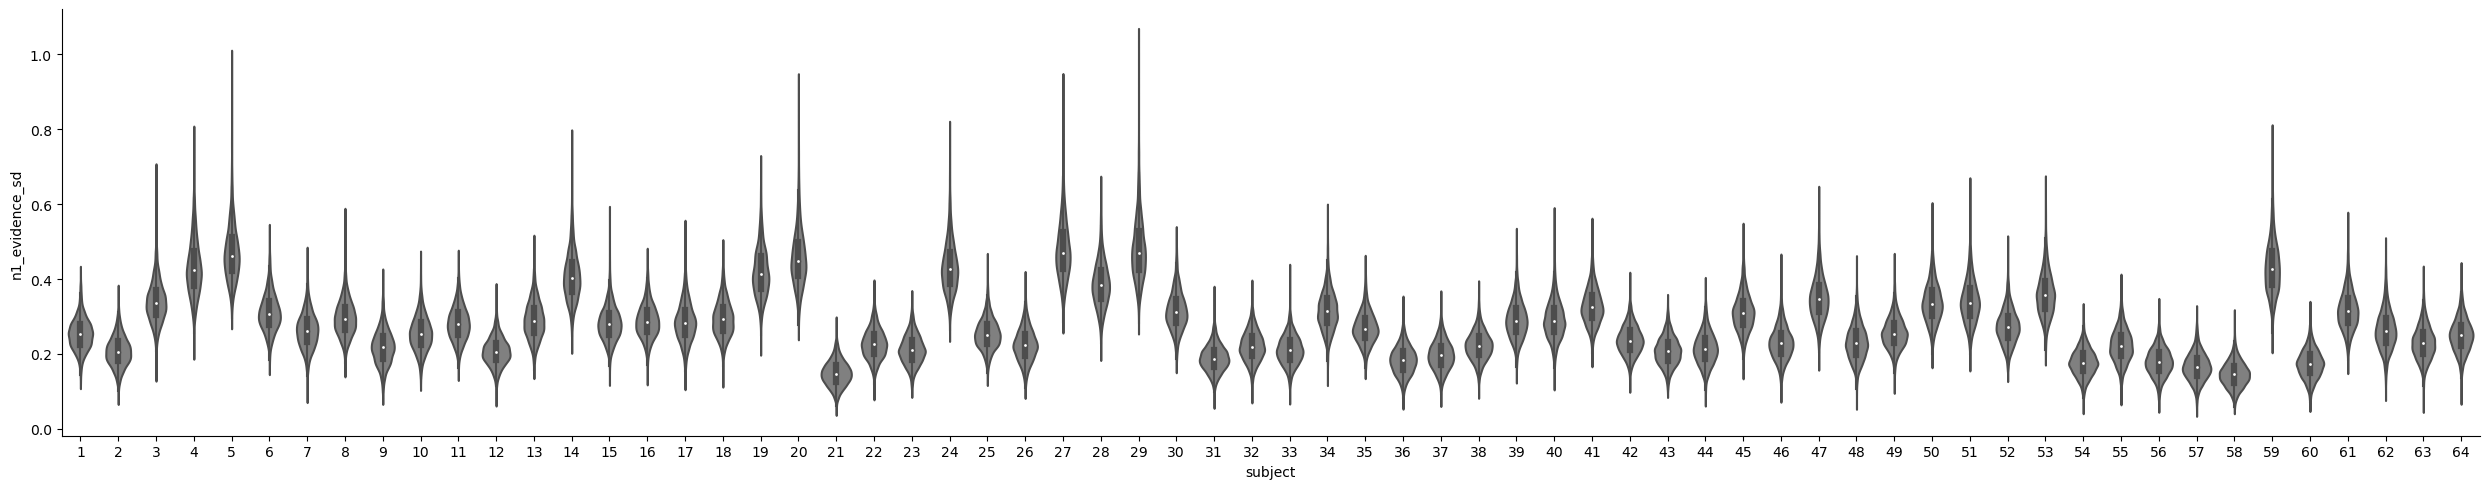

In [37]:
ddd = trace_denom10.posterior['n1_evidence_sd'].to_dataframe()
sns.catplot(x='subject', y='n1_evidence_sd', data=ddd.reset_index(), aspect=5., kind='violin', color='gray')

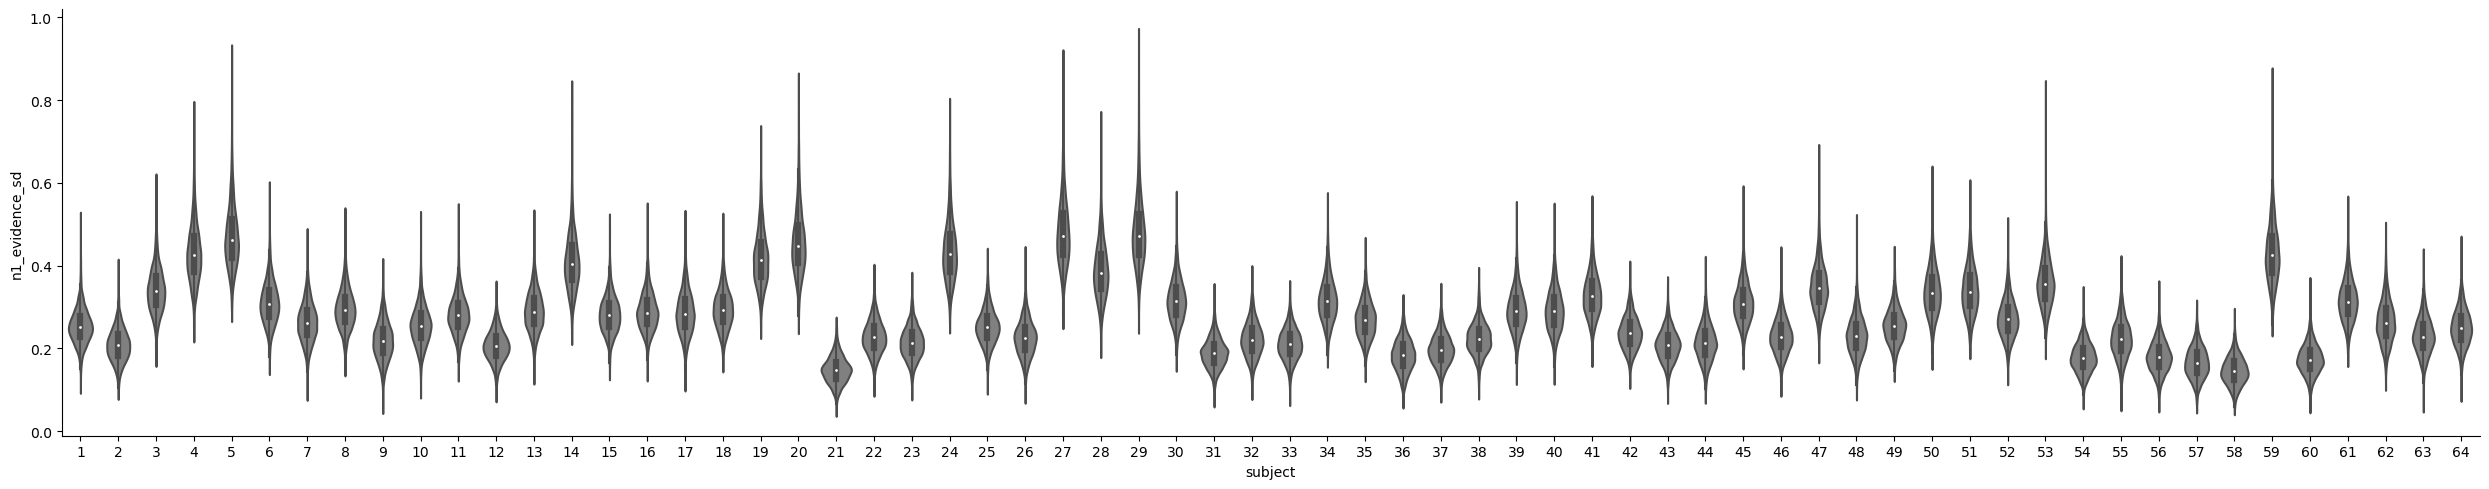

In [9]:
ddd = trace_denom6.posterior['n1_evidence_sd'].to_dataframe()
sns.catplot(x='subject', y='n1_evidence_sd', data=ddd.reset_index(), aspect=5., kind='violin', color='gray')

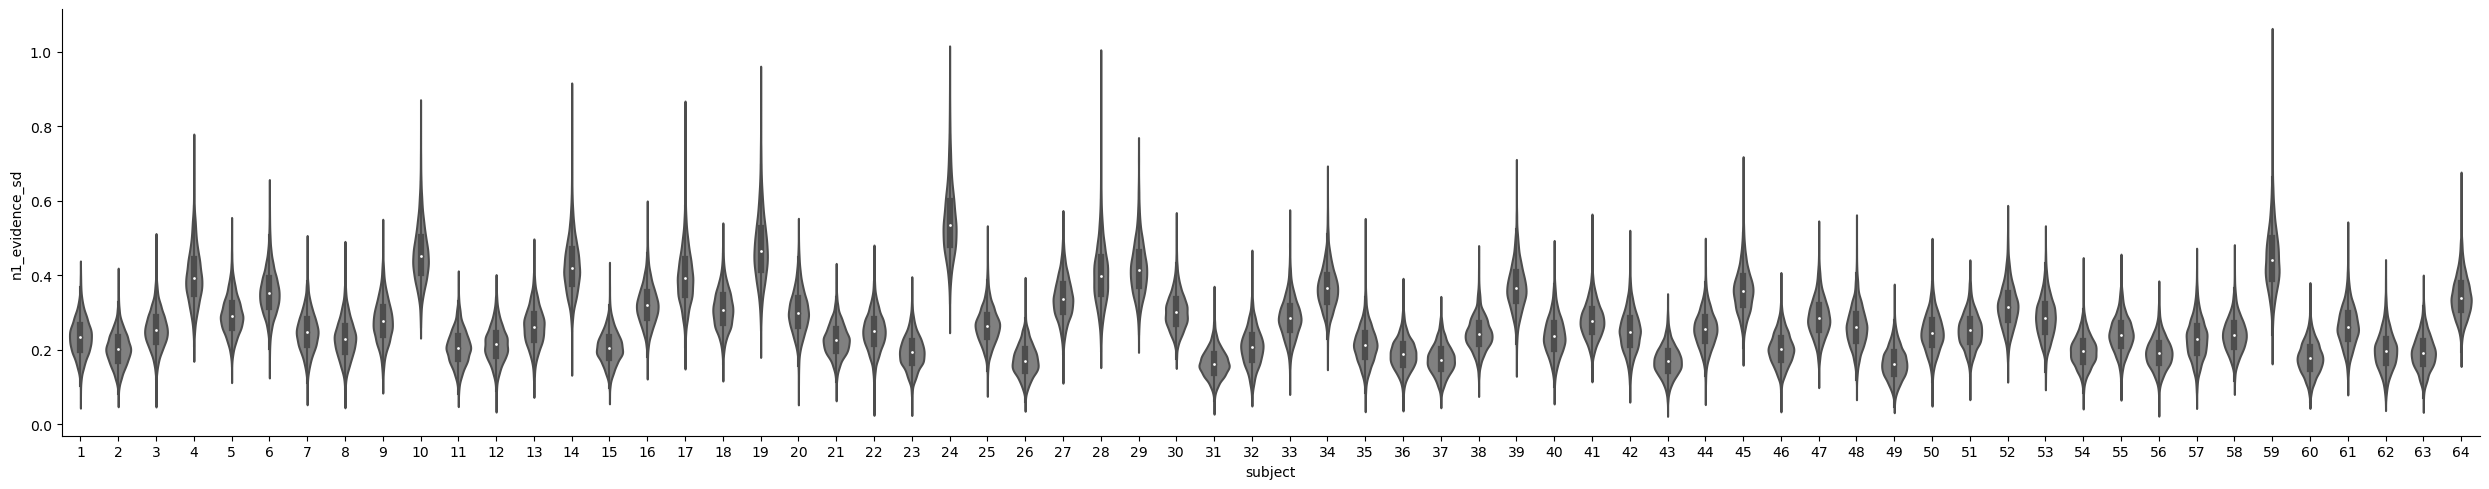

In [11]:
ddd = trace_denom4.posterior['n1_evidence_sd'].to_dataframe()
sns.catplot(x='subject', y='n1_evidence_sd', data=ddd.reset_index(), aspect=5., kind='violin', color='gray')

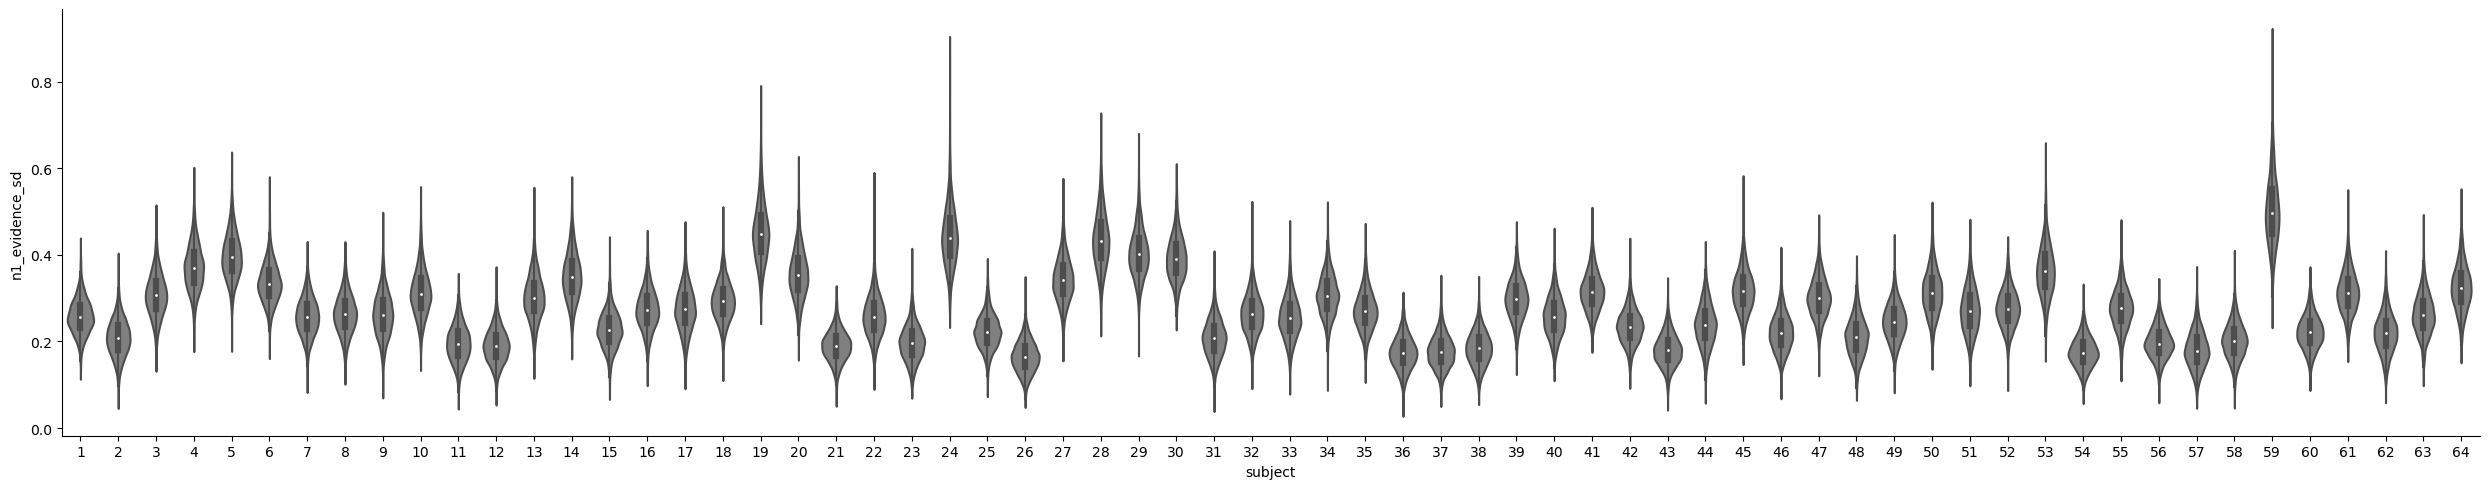

In [166]:
ddd = trace.posterior['n1_evidence_sd'].to_dataframe()
sns.catplot(x='subject', y='n1_evidence_sd', data=ddd.reset_index(), aspect=5., kind='violin', color='gray')

In [12]:
denom4 = trace_denom4.posterior['n1_evidence_sd'].to_dataframe()
denom6 = trace_denom6.posterior['n1_evidence_sd'].to_dataframe()



In [21]:
denominator = 6 # before = 4
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions6 = np.power(2,(frac/denominator))


In [82]:
denominator = 4 # before = 4
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions = np.power(2,(frac/denominator))

df = create_design_magJudge(fractions, repetitions=3, n_runs= 6)
df.sort_values('fraction').to_csv('/Users/mrenke/git/numrisk/behavior_simulations/denom4_trials.csv')


In [83]:
denominator = 10 # before = 4
frac = np.linspace(-6,6, 13)
frac = np.delete(frac, 6)                     
fractions = np.power(2,(frac/denominator))

df = create_design_magJudge(fractions, repetitions=3, n_runs= 6)
df.sort_values('fraction').to_csv('/Users/mrenke/git/numrisk/behavior_simulations/denom10_trials.csv')


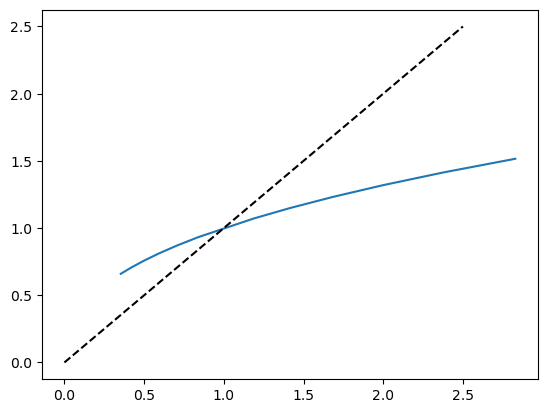

In [35]:
import matplotlib.pyplot as plt
plt.plot(fractions4, fractions10)
ident = [0.0, 2.5]
plt.plot(ident,ident,linestyle='dashed',color = 'black' )

In [38]:
denom4 = trace_denom4.posterior['n1_evidence_sd'].to_dataframe()
denom6 = trace_denom6.posterior['n1_evidence_sd'].to_dataframe()
denom10 = trace_denom10.posterior['n1_evidence_sd'].to_dataframe()


Text(0.5, 0, 'std_denom4 - std_denom10')

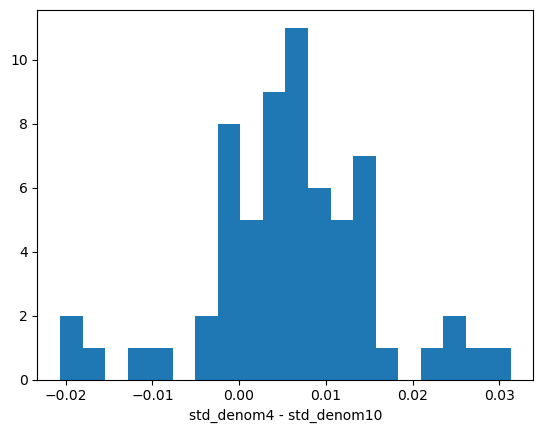

In [67]:
diff_std_d4_d10 = denom4.groupby('subject').std() - denom10.groupby('subject').std()

plt.hist(diff_std_d4_d10, bins=20)
plt.xlabel('std_denom4 - std_denom10')

In [140]:
denominator = 10
if denominator == 4:
    denom = denom4
elif denominator == 6:
    denom = denom6
elif denominator == 10:
    denom = denom10

dc = pd.DataFrame(data={'evid_sd_std': denom.groupby('subject').std()['n1_evidence_sd'],'evid_sd_mu':denom.groupby('subject').mean()['n1_evidence_sd'], 'true_evid_sd_mu': sub_params.set_index('subject')['n1_evidence_sd'] })
dc['evid_sd_std'].mean()

0.04812216953391828

Text(0.5, 1.0, 'denom10, cc = 0.97, p-value = 0.0')

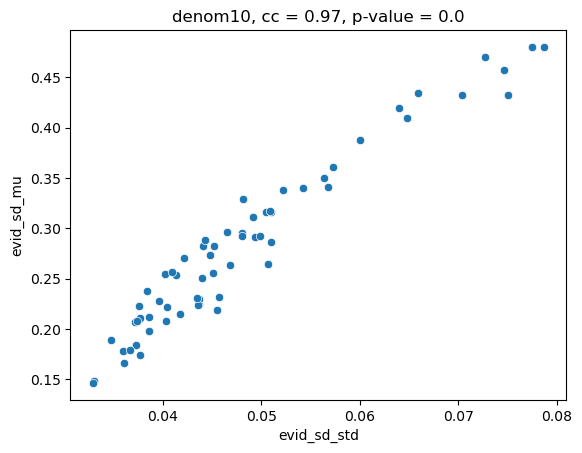

In [135]:
x = 'evid_sd_std'
y = 'evid_sd_mu'
cc = pearsonr(dc[x], dc[y])
sns.scatterplot(dc, x = x,y = y )
plt.title(f'denom{denominator}, cc = {round(cc[0],2)}, p-value = {round(cc[1],4)}')

Text(0.5, 1.0, 'denom10, cc = 0.86, p-value = 0.0')

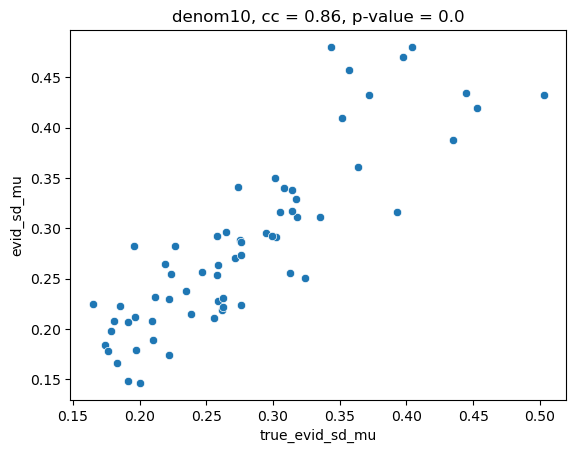

In [136]:
x = 'true_evid_sd_mu'
y = 'evid_sd_mu'
cc = pearsonr(dc[x], dc[y])
sns.scatterplot(dc, x = x,y = y )
plt.title(f'denom{denominator}, cc = {round(cc[0],2)}, p-value = {round(cc[1],4)}')